<p style="width:35%;float:right;padding-left:50px">
<img src=http://www.geophysik.uni-muenchen.de/~igel/snap.png?raw=true>
<span style="font-size:smaller">
from <span style="font-style: italic">Nissen-Meyer et al. (2014). AxiSEM: broadband 3-D seismic wavefields in axisymmetric media. Solid Earth, 5(1), 425–445.</span>
</span>
</p>

# Computational Seismology 


## *The Fourier Pseudospectral Method - Acoustic Waves in 1D*


**Authors:** *Fabian Lindner, Florian Wölfl and Heiner Igel*

This exercise covers the following aspects:

* presenting you with an implementation of the 2D acoustic wave equation
* allowing you to explore the benefits of calculating exact spatial derivatives (up to machine precision)
* determination of the stability limit for the Pseudospectral Fourier Method
* exploration of numerical dispersion
* comparison of the Pseudospectral Fourier Method with a 5-point Finite Difference scheme

<div style="clear:both"></div>




## Exercises

### 1. Getting started
Before you start it is good practice to immediately make a copy of the original notebook (e.g., X_orig.ipynb). 
Run the simulation code. Relate the spatial derivative calculation via Fast Fourier Transform (FFT) with the numerical algorithm we developed in the course. Understand the input parameters for the simulation and the plots that are generated. 

### 2. Stability
Determine numerically the stability limit of the code as accurately as possible by varying the Courant criterion eps. (Hint: The Courant criterion is defined as eps = (velocity * dt) / dx . With this information you can calculate the maximum possible, stable time step. )

### 3. Heterogeneous models
Implement a positive velocity discontinuity of 50% at the centre of the 2D domain. Observe the reflection as a function of dominant wavelength (i.e., change the dominant frequency of the source wavelet).


### 4. Comparison to Finite Differences
Go back to a homogeneous velocity distribution and compare the resulting seismograms with a 5-point finite difference solution by setting "FD = 1" in the parameter initialization. Compare and discuss the computational setups in terms of memory requirements, number of time steps, Courant criterion and computatational time.

### Have fun!

In [1]:
# This is a configuration step for the exercise. Please run it before the simulation code!
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import gridspec
# Show the plots in the Notebook.
plt.switch_backend("nbagg")

Below there is the code solving the 2D acoustic wave equation by using the 1D acoustic wave equation
$$ \partial_t^2 p(x,t) = c(x)^2 \ \partial_x^2 p(x,t) + s(x,t)$$
seperately in the x and y domain.

In [2]:
# Parameters
nx = 512     # space dimension
nz = 512
isx = 256      # source location
isz = 256
nt = 10000      # number of time steps
dx = 20.       # grid spacing in m
dz = 20.       # grid spacing in m
dt = .002     # time increment
it0 = 30       # source time
freq = 10      # source frequency
ir = 300       # receiver location
idisp = 5    # display frequency
ag = 1. * dx   # gaussian in space for source
FD = 1       # fd solution is plotted if set to 1


# initialization of the velocity distribution
c = np.zeros(nx)
c = c + 2000. 
# initialization of grid
a=np.arange(0,512)
tempx,tempy=np.meshgrid(a,a)
x=np.dstack((tempy,tempx))
x = x * dx
# initialization of space dependent fields

p = np.zeros((nx,nz))        # pressure PSM
p_fd = np.zeros((nx,nz))     # pressure FDM
d2xp = np.zeros((nx,nz))      # pressure 2nd derivative x domain PSM
d2zp = np.zeros((nx,nz))      # pressure 2nd derivative z domain PSM
d2xp_fd = np.zeros((nx,nz))   # pressure 2nd derivative x domain FDM
d2zp_fd = np.zeros((nx,nz))   # pressure 2nd derivative x domain FDM
pold = np.zeros((nx,nz))     # pressure at previous time step PSM
pold_fd = np.zeros((nx,nz))  # pressure at previous time step FDM 
pnew = np.zeros((nx,nz))     # pressure at next time step PSM
pnew_fd = np.zeros((nx,nz))  # pressure at next time step FDM
# initialization of empty seismogram
seis = np.zeros(nt) #PSM
seis_fd = np.zeros(nt) #FDM
time = np.linspace(0, nt * dt, num=nt)
 

# Source time function
src = np.zeros(nt)
# Ricker wavelet
t0 = 4 / (freq * np.pi)
t = np.arange(1, nt + 1) * dt
src = (np.sqrt(np.pi) / 2) * (freq * np.pi * (t - t0)) * np.exp(-(freq * np.pi * (t - t0) ) **2)
src = np.diff(src)
src = src / np.max(src)
# append one entry as one is lost in differentiation
src = np.append(src, 0.0)
# spatial distribution of source
gauss = np.zeros(nx)
if ag == 0.:
    gauss[isx] = 1
else:
    X = np.arange(0, nx, 1)
    Z = np.arange(0, nz, 1)
    X, Z = np.meshgrid(X, Z)
    r = np.sqrt((X-isx)**2 + (Z-isz)**2)
    gauss = np.exp(- 1 / ag **2 * r ** 2)

The second spatial derivative is computed by multiplying the spatial Fourier transform of the pressure field $P(k,t)$ with $ (ik)^2 $

$$ \partial_x^2 p(x,t) \ = \ IFT[(ik)^2 P(k,t)]  $$

where $k$ is the wavenumber and $IFT$ the Inverse Fourier Transform.

In [6]:
# Function for calculating the 2nd spatial derivative
def sder2d(f,nx,dx):
    # initialize 
    kmax = np.pi / dx
    dk = kmax / (nx / 2)
    k = np.arange(float(nx))
    k[: nx /2] = k[: nx /2] * dk 
    k[nx /2:] = k [: nx /2] - kmax
    k = (1j * k ) ** 2
    # FFT and IFFT
    ff = np.fft.fft(f)
    ff = k * ff
    df = np.real(np.fft.ifft(ff))
    return df
def fin2nd(f,nx):
    f2nd = np.zeros(nx)
    for i in range(2, nx - 2):
        f2nd[i] = -1. / 12. * f[i + 2] + 4. / 3. * f[i + 1] - 5. / 2. * f[i] + 4. / 3. * f[i - 1] - 1. / 12. * f[i - 2]
    return f2nd


The cell allows you to plot the source time function, the width of the Gauss Puls, the propagation of the puls along the line as computed by the Pseudospectral method (and in comparison the FD scheme) and the recorded signal. For comparison the solution of the acoustic wave equation for a 5-point Finite Difference Scheme can also be ploted.


<IPython.core.display.Javascript object>


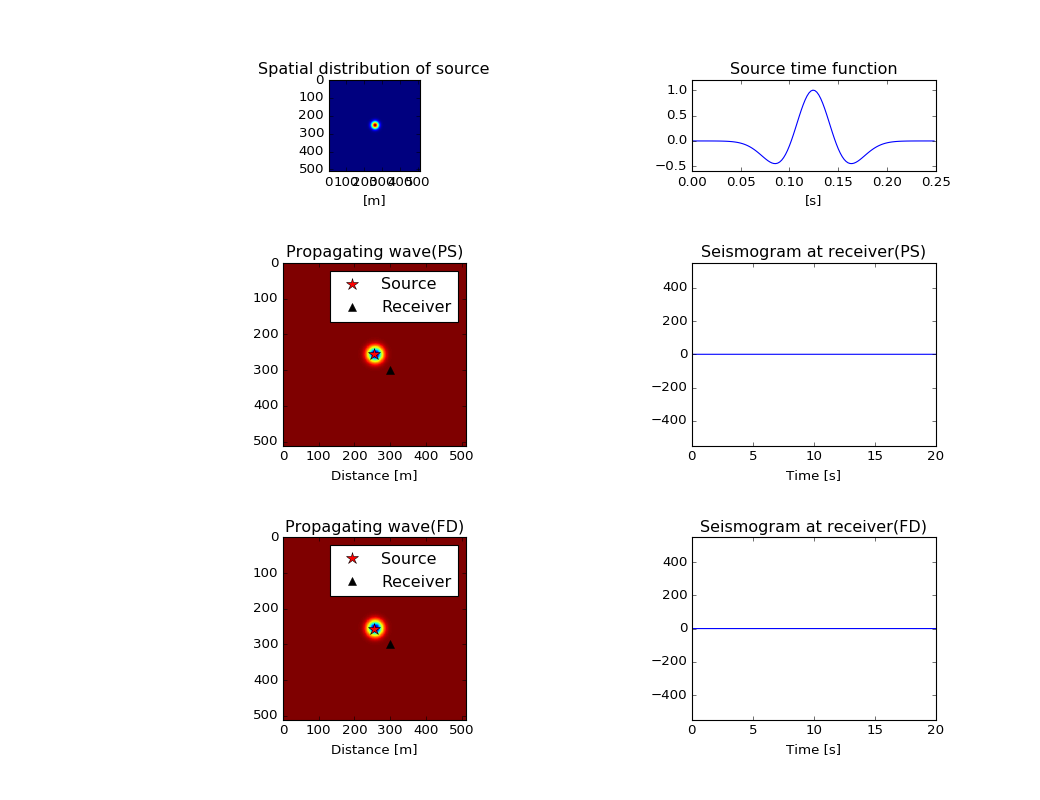

In [7]:
# Stability condition
#print 'Stability criterion: %.2f' % ( c[0] * dt / dx)

# Initialize plots
plt.ion()
fig = plt.figure(figsize=(13,10))
gs = gridspec.GridSpec(3,2,width_ratios=[2,1],height_ratios=[1,2,2],hspace=0.6)
ax1 = plt.subplot(gs[1])
length = 2.5 * 1./ float(freq)
frac = int((length / time[-1]) * nt)
ax1.plot(time[:frac], src[:frac])
ax1.set_title('Source time function')
ax1.set_xlabel('[s]')

ax2 = plt.subplot(gs[0])
ax2.imshow(gauss)
ax2.set_title('Spatial distribution of source')
ax2.set_xlabel('[m]')

ax3 = plt.subplot(gs[2])
ax3.set_title('Propagating wave(PS)')
ax3.set_xlabel('Distance [m]')
leg1, = ax3.plot(isx,isz, 'r*', markersize=11) 
leg2, = ax3.plot(ir,ir, 'k^', markersize=8)
ax3.legend((leg1, leg2), ('Source', 'Receiver'), loc='upper right', numpoints=1)
upd31 = ax3.imshow(p,vmin=0, vmax=1)   # comma is needed to update the variable
lim = 0.55 / float(freq) * 10000
if FD == 1:
    ax5 = plt.subplot(gs[4])
    ax5.set_title('Propagating wave(FD)')
    ax5.set_xlabel('Distance [m]')
    leg51, = ax5.plot(isx,isz, 'r*', markersize=11) 
    leg52, = ax5.plot(ir,ir, 'k^', markersize=8)
    upd51 = ax5.imshow(p_fd,vmin=0, vmax=1)   # comma is needed to update the variable
    ax5.legend((leg1, leg2), ('Source', 'Receiver'), loc='upper right', numpoints=1)
    ax6 = plt.subplot(gs[5])
    upd61, = ax6.plot(time, seis_fd)
    upd62, = ax6.plot([0], [0], 'b|', markersize=15)
    ax6.set_ylim(-lim, lim)
    ax6.set_xlim(time[0], time[-1])
    ax6.set_title('Seismogram at receiver(FD)')
    ax6.set_xlabel('Time [s]')

ax4 = plt.subplot(gs[3])
upd41, = ax4.plot(time, seis)
upd42, = ax4.plot([0], [0], 'b|', markersize=15)
lim = 0.55 / float(freq) * 10000
ax4.set_ylim(-lim, lim)
ax4.set_xlim(time[0], time[-1])
ax4.set_title('Seismogram at receiver(PS)')
ax4.set_xlabel('Time [s]')
plt.show()

The calculation of the temporal derivative is done with a 3-point finite difference operator:
$$ \partial_t^2 p(x,t) = \frac{p(x,t+\mathrm{d}t) - 2 p(x,t) + p(x,t-\mathrm{d}t)}{\mathrm{d}t^2} $$




In [ ]:
# Begin time extrapolation
#print 'Time extrapolation ...'
for it in range(nt):
    # pseudospectral - fourier
    # laplacian with spectral derivative
    for j in range(2,nz-2):
        d2xp[:,j]=sder2d(np.transpose(p[:,j]),nz,dz);
    for i in range(2,nx-2):
        d2zp[i,:]=sder2d(p[i,:],nx,dx);
    
    pnew = 2 * p - pold + c ** 2 * dt ** 2 * ((d2xp + d2zp) + gauss * src[it])
    pold = p
    p = pnew
    
    # Calculate also FD solution
    # second spatial derivative
    for j in range(nz):
        d2xp_fd[:,j]=fin2nd(np.transpose(p_fd[:,j]),nz);
    for i in range(nx):
        d2zp_fd[i,:]=fin2nd(p_fd[i,:],nx);
    d2xp_fd /= dx ** 2
    d2zp_fd /= dx ** 2
    # add source and compute new pressure field
    pnew_fd = 2 * p_fd - pold_fd + c ** 2 * dt ** 2 * ((d2xp_fd + d2zp_fd) + gauss * src[it])

    pold_fd = p_fd
    p_fd = pnew_fd 

    # output
    seis_fd[it] = p_fd[ir,ir]

    # output
    seis[it] = p[ir,ir]
    # update data for plot
    if (it % idisp) is 0:
        ax3.imshow(p,vmin=p.min(), vmax=p.max(), interpolation="nearest")
        upd41.set_ydata(seis)
        upd42.set_data(time[it], seis[it])
        if FD == 1:
            ax5.imshow(p_fd,vmin=p_fd.min(), vmax=p_fd.max(), interpolation="nearest")
            upd62.set_data(time[it], seis_fd[it])
        fig.canvas.draw()
#print 'done ...'

/home/david/Programs/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/david/Programs/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
